# Predict pitch parameter

In [1]:
import numpy as np
import h5py
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import SGD, Adadelta
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
hidden_layers = 6

## Keras model
* DNN with simple tanh activations, and sigmoid for the last

In [3]:
nlayers=1024
model = Sequential()
model.add(Dense(nlayers, input_dim=215, activation='tanh', init = 'glorot_normal'))
model.add(Dropout(0.5))
for i in range(0,hidden_layers):
    model.add(Dense(nlayers, activation='tanh',init = 'glorot_normal'))
    model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()        

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 1024)          221184      dense_input_1[0][0]              
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 1024)          0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1024)          1049600     dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 1024)          0           dense_2[0][0]                    
___________________________________________________________________________________________

### Early stopping and optimizer

In [4]:
early_stopping = EarlyStopping(patience=16)

In [5]:
model.compile(optimizer=SGD(lr=0.1, momentum=0.75, nesterov=False), loss='mse', metrics=['accuracy'])

### Import train and validation data

In [6]:
data = []
with h5py.File('preprocessed_data/train-standardized.h5','r') as hf:
    data = np.array(hf.get('dataset'))
input_data = data[:,0:215]
print(input_data.shape)
target_data = data[:,215:216]
target_data = target_data
print(target_data.shape)

(216559, 215)
(216559, 1)


In [7]:
maxs = np.max(target_data, axis=0)
mins = np.min(target_data, axis=0)
target_data = (target_data-mins)/(maxs-mins)

Validation data

In [8]:
data_validation = []
with h5py.File('preprocessed_data/validation.h5','r') as hf:
    data_validation = np.array(hf.get('dataset'))
input_validation = data_validation[:,0:215]
print(input_validation.shape)
target_validation = data_validation[:,215:216]
target_validation = target_validation
print(target_validation.shape)

(12594, 215)
(12594, 1)


In [9]:
mean = []
with h5py.File('preprocessed_data/train-mean.h5') as hf:
    mean = np.array(hf.get('dataset'))
sdt = []
with h5py.File('preprocessed_data/train-mean.h5') as hf:
    std = np.array(hf.get('dataset'))

In [10]:
input_validation2 = (input_validation-mean[0:215])/(std[0:215])

In [11]:
target_validation = (target_validation-mins)/(maxs-mins)

## Train

In [25]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir='log_pitch_n2', histogram_freq=0, write_graph=True, write_images=False)

In [26]:
model.fit(input_data, target_data, nb_epoch=1000, 
          validation_data=(input_validation2, target_validation),batch_size=512, verbose=1,
         callbacks=[early_stopping, tensorboard_callback])

Train on 216559 samples, validate on 12594 samples
Epoch 1/1000
216559/216559 [==============================] - 8s - loss: 0.0273 - acc: 0.4482 - val_loss: 0.0717 - val_acc: 0.4088
Epoch 2/1000
216559/216559 [==============================] - 8s - loss: 0.0271 - acc: 0.4481 - val_loss: 0.0676 - val_acc: 0.4098
Epoch 3/1000
216559/216559 [==============================] - 8s - loss: 0.0271 - acc: 0.4481 - val_loss: 0.0775 - val_acc: 0.4071
Epoch 4/1000
216559/216559 [==============================] - 8s - loss: 0.0273 - acc: 0.4480 - val_loss: 0.0648 - val_acc: 0.4132
Epoch 5/1000
216559/216559 [==============================] - 8s - loss: 0.0271 - acc: 0.4482 - val_loss: 0.0705 - val_acc: 0.4094
Epoch 6/1000
216559/216559 [==============================] - 8s - loss: 0.0270 - acc: 0.4480 - val_loss: 0.0701 - val_acc: 0.4093
Epoch 7/1000
216559/216559 [==============================] - 8s - loss: 0.0271 - acc: 0.4479 - val_loss: 0.0671 - val_acc: 0.4118
Epoch 8/1000
216559/216559 [====

In [16]:
model.save('models_data/model_pitch.h5')
model.save_weights('models_data/model_pitch_weights.h5')

h5f = h5py.File('models_data/max_min_pitch.h5', 'w')
h5f.create_dataset('dataset',data=[maxs,mins])
h5f.close()

## Evaulation

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

### Import test data

In [18]:
data_test = []
with h5py.File('preprocessed_data/test.h5','r') as hf:
    data_test = np.array(hf.get('dataset'))
    
#Using example test sentence
#import generate_training_set as gt
#data_test = gt.generate_sentence_data(["arctic_a0348","Get down and dig in."])
#data_test = np.array(data_test)
    
input_test = data_test[:,0:215]
print(input_test.shape)
target_test = data_test[:,215:216]
print(target_test.shape)

(12249, 215)
(12249, 1)


In [19]:
target_test2 = (target_test-mins)/(maxs-mins)

In [20]:
input_test2 = (input_test-mean[0:215])/(std[0:215])

In [21]:
evaulate_data = model.evaluate(input_test2, target_test2, batch_size=32, verbose=1, sample_weight=None)

12224/12249 [============================>.] - ETA: 0s

In [22]:
evaulate_data

[0.07214233030824202, 0.42427953302797]

In [23]:
output_test = []
for test in input_test2:
    test = np.array(test)
    test = test.reshape(1,215)
    output_test.append(model.predict(test).reshape(1))
output_test= np.asarray(output_test)

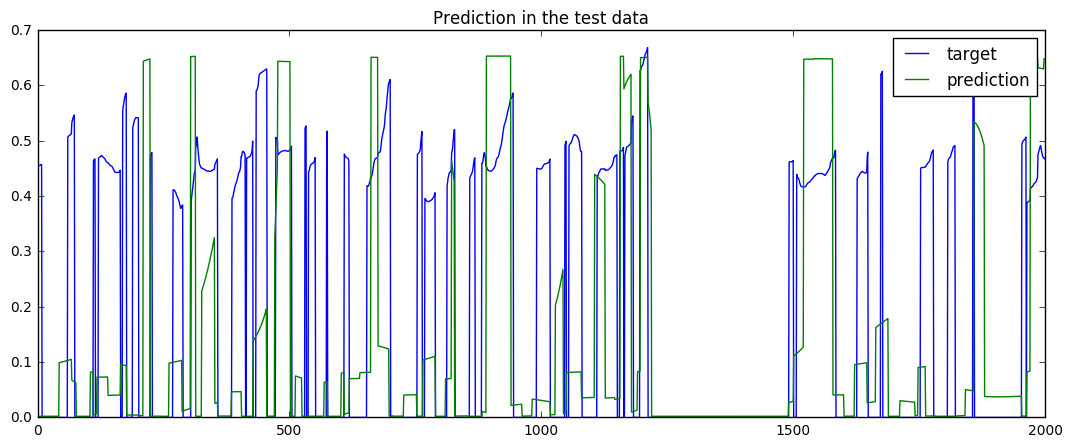

In [24]:
plt.figure(figsize=(13,5))
plt.title('Prediction in the test data')
plt.plot(target_test2[500:2500], label='target')
plt.plot(output_test[500:2500], label='prediction')
plt.legend()
plt.show()